In [129]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from scipy.optimize import nnls

In [130]:
def load_and_preprocess_data(data_path):
    print("Loading and preprocessing data...")
    data = pd.read_excel(data_path)

    # Handle missing values
    data = data.fillna(0)

    # Add Year_month column if needed
    if 'order_date' in data.columns and 'Year_month' not in data.columns:
        data['Year_month'] = pd.to_datetime(data['order_date']).dt.strftime('%Y-%m')

    # Calculate total spend per channel and total GMV
    marketing_channels = [
        'TV', 'Digital', 'Sponsorship', 'Content_Marketing',
        'Online_marketing', 'Affiliates', 'SEM', 'Radio', 'Other'
    ]
    total_spend_per_channel = {ch: data[ch].sum() for ch in marketing_channels}
    total_marketing_budget = sum(total_spend_per_channel.values())
    total_gmv = data['gmv'].sum()
    total_days = len(data)

    print(f"Data loaded successfully: {total_days} days")
    print(f"Total GMV: {total_gmv:.2f}")
    print(f"Total Marketing Budget: {total_marketing_budget:.2f}")

    return data, total_spend_per_channel, total_marketing_budget, total_gmv, total_days

# Execute preprocessing
data_path = '/content/drive/MyDrive/Data/litterman_disaggregation.xlsx'
data, total_spend_per_channel, total_marketing_budget, total_gmv, total_days = load_and_preprocess_data(data_path)

Loading and preprocessing data...
Data loaded successfully: 361 days
Total GMV: 3810634123.86
Total Marketing Budget: 846.33


In [131]:
data.drop(columns = ['Unnamed: 0', 'gmv_normalized', 'Year_month',], inplace=True)
base_feats = ['holiday', 'sale', 'sla', 'pay_day', 'units_roll3', 'gmv_roll3', 'gmv_roll7', 'units_roll7']

In [133]:
# Define marketing channels and baseline features
MARKETING_CHANNELS = ['TV', 'Digital', 'Sponsorship', 'Content_Marketing',
                      'Online_marketing', 'Affiliates', 'SEM', 'Radio', 'Other']
BASELINE_FEATURES = ['holiday', 'sale', 'sla', 'pay_day', 'units_roll3',
                     'gmv_roll3', 'units_roll7', 'gmv_roll7']

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

print(f"Training set: {len(train_data)} days")
print(f"Test set: {len(test_data)} days")

# Function to remove outliers using IQR (Interquartile Range)
def remove_outliers(data, column, threshold=1.5):
    Q1 = data[column].quantile(0.25)  # First quartile
    Q3 = data[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Filter out rows outside the bounds
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data

# Remove outliers from the training data
train_data_cleaned = remove_outliers(train_data, 'gmv', threshold=1.5)

# Train NNLS model
def train_nnls(train, features, channels):
    print("Training Non-Negative Least Squares (NNLS) model...")
    # Prepare data
    X_train = train[features + channels].values
    y_train = train['gmv'].values

    # Train NNLS model
    coefficients, _ = nnls(X_train, y_train)

    return coefficients

# Execute training with NNLS
nnls_coefficients = train_nnls(train_data_cleaned, BASELINE_FEATURES, MARKETING_CHANNELS)

# Predict using NNLS coefficients
def calculate_nnls_baseline(coefficients, data, features, channels):
    print("Calculating baseline GMV (no marketing spend) with NNLS...")
    # Create baseline scenario
    baseline_data = data.copy()
    for ch in channels:
        baseline_data[ch] = 0  # Zero out all marketing spend

    # Predict GMV
    X_baseline = baseline_data[features + channels].values
    baseline_predictions = X_baseline @ coefficients

    # Calculate average baseline gmv
    baseline_gmv = 2*baseline_predictions.mean()
    print(f"Predicted Baseline GMV (Total): {baseline_gmv:.2f}")

    return baseline_gmv

# Calculate baseline for training data with NNLS
train_baseline_gmv = calculate_nnls_baseline(nnls_coefficients, train_data_cleaned, BASELINE_FEATURES, MARKETING_CHANNELS)

Training set: 288 days
Test set: 73 days
Training Non-Negative Least Squares (NNLS) model...
Calculating baseline GMV (no marketing spend) with NNLS...
Predicted Baseline GMV (Total): 10753393.55


In [134]:
###############################################
# All channel coefficients are already positive
###############################################

In [135]:
def run_individual_channel_models(data, marketing_channels, baseline_features):
    print("Running individual channel models...")
    channel_coefficients = {}

    # Filter available baseline features
    available_features = [f for f in baseline_features if f in data.columns]

    for channel in marketing_channels:
        # Prepare features: baseline + this channel
        X = data[available_features + [channel]]
        y = data['gmv']

        # Add constant for intercept
        X = sm.add_constant(X)

        # Fit OLS regression
        model = sm.OLS(y, X).fit()

        # Extract coefficient for the channel
        channel_coefficient = model.params[channel]
        channel_pvalue = model.pvalues[channel]

        # Store results
        channel_coefficients[channel] = {
            'coefficient': channel_coefficient,
            'p_value': channel_pvalue
        }

        # Print results
        print(f"{channel}: Coefficient={channel_coefficient:.2f}, p-value={channel_pvalue:.4f}")

    return channel_coefficients

# Execute
channel_coefficients = run_individual_channel_models(
    data, MARKETING_CHANNELS, ['holiday', 'sale', 'pay_day', 'sla']
)

Running individual channel models...
TV: Coefficient=70682538.85, p-value=0.0000
Digital: Coefficient=43401437.63, p-value=0.0000
Sponsorship: Coefficient=5868510.34, p-value=0.0000
Content_Marketing: Coefficient=164334689.52, p-value=0.0000
Online_marketing: Coefficient=25021018.08, p-value=0.0000
Affiliates: Coefficient=84394631.34, p-value=0.0000
SEM: Coefficient=18516539.70, p-value=0.0000
Radio: Coefficient=60542906.92, p-value=0.0001
Other: Coefficient=6143668.91, p-value=0.0001


In [136]:
def calculate_saturation_levels(total_spend_per_channel, adjusted_coefficients):
    print("Calculating saturation levels...")
    saturation_levels = {}

    for channel in MARKETING_CHANNELS:
        # Base saturation is 3x current spend
        base_saturation = total_spend_per_channel[channel]

        # Adjust based on ROI
        roi = abs(adjusted_coefficients[channel]['coefficient']) / (total_spend_per_channel[channel] or 1)
        roi_adjustment = min(max(roi / 10000, 1), 1.2)
        saturation_levels[channel] = base_saturation * roi_adjustment
        print(f"{channel} saturation level: {saturation_levels[channel]:.2f}")

    return saturation_levels

# Ensure inputs are correct
saturation_levels = calculate_saturation_levels(total_spend_per_channel, channel_coefficients)

Calculating saturation levels...
TV saturation level: 53.24
Digital saturation level: 35.59
Sponsorship saturation level: 438.44
Content_Marketing saturation level: 9.63
Online_marketing saturation level: 232.37
Affiliates saturation level: 73.64
SEM saturation level: 109.44
Radio saturation level: 5.60
Other saturation level: 57.63


In [137]:
def hill_function(spend, beta, n, ec50):
    return beta * (spend**n / (ec50**n + spend**n))

In [138]:
from scipy.optimize import curve_fit

def fit_hill_parameters(channel_spend, channel_gmv, beta):
    # Initial guesses for n and EC50
    initial_guess = [1.5, np.median(channel_spend)]  # Start with n=1.5 and EC50=median spend

    try:
        # Perform curve fitting
        params, _ = curve_fit(
            lambda spend, n, ec50: hill_function(spend, beta, n, ec50),
            channel_spend,
            channel_gmv,
            p0=initial_guess,
            bounds=([0.1, 0], [5, max(channel_spend)])  # Reasonable bounds for n and EC50
        )
        n, ec50 = params
        return n, ec50
    except Exception as e:
        print(f"Curve fitting failed: {e}")
        return None, None

In [139]:
def determine_hill_coefficients(data, marketing_channels, channel_coefficients):
    print("Determining Hill coefficients algorithmically...")
    hill_coefficients = {}
    half_saturation_points = {}

    for channel in marketing_channels:
        channel_spend = data[channel]
        channel_gmv = data['gmv']
        beta = channel_coefficients[channel]['coefficient']

        n, ec50 = fit_hill_parameters(channel_spend, channel_gmv, beta)
        if n is not None and ec50 is not None:
            hill_coefficients[channel] = n
            half_saturation_points[channel] = ec50
            print(f"{channel}: Hill={n:.2f}, EC50={ec50:.2f}")
        else:
            print(f"{channel}: Failed to fit Hill parameters")

    return hill_coefficients, half_saturation_points

In [140]:
# Assuming `data` contains marketing spend and GMV data
hill_coefficients, half_saturation_points = determine_hill_coefficients(
    data, MARKETING_CHANNELS, channel_coefficients
)

Determining Hill coefficients algorithmically...
TV: Hill=1.57, EC50=0.47
Digital: Hill=0.87, EC50=0.31
Sponsorship: Hill=5.00, EC50=0.01
Content_Marketing: Hill=0.81, EC50=0.75
Online_marketing: Hill=3.11, EC50=0.68
Affiliates: Hill=2.87, EC50=0.41
SEM: Hill=0.79, EC50=0.12
Radio: Hill=0.63, EC50=0.34
Other: Hill=1.50, EC50=0.00


In [141]:
#########################################
# found hill coefficients algorithmically
#########################################

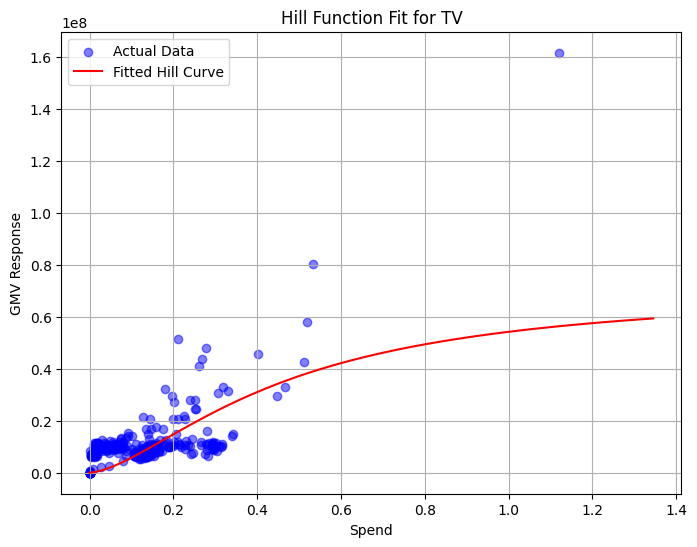

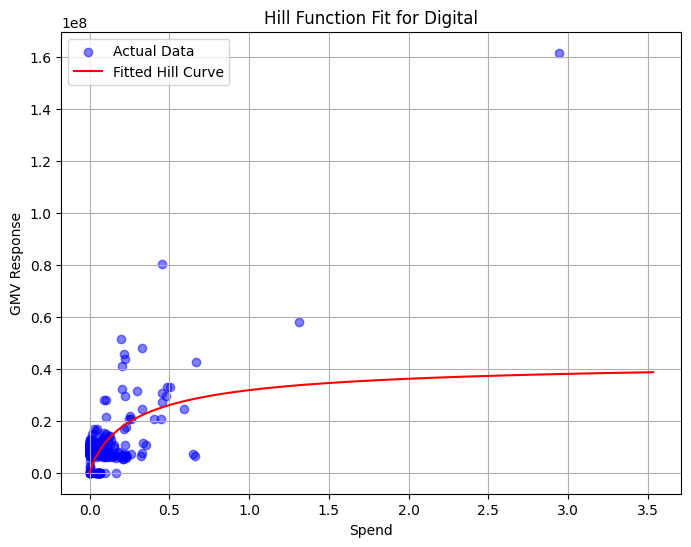

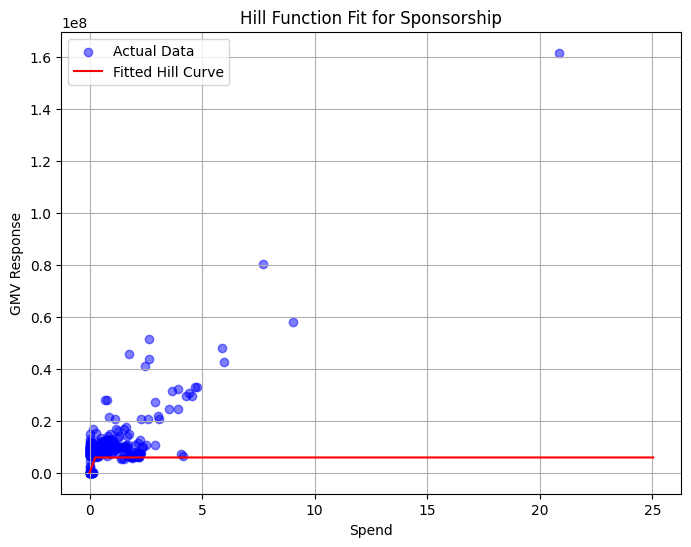

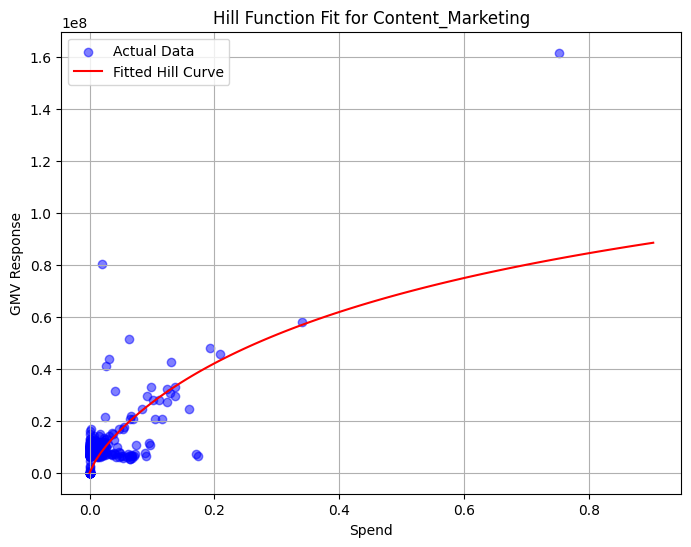

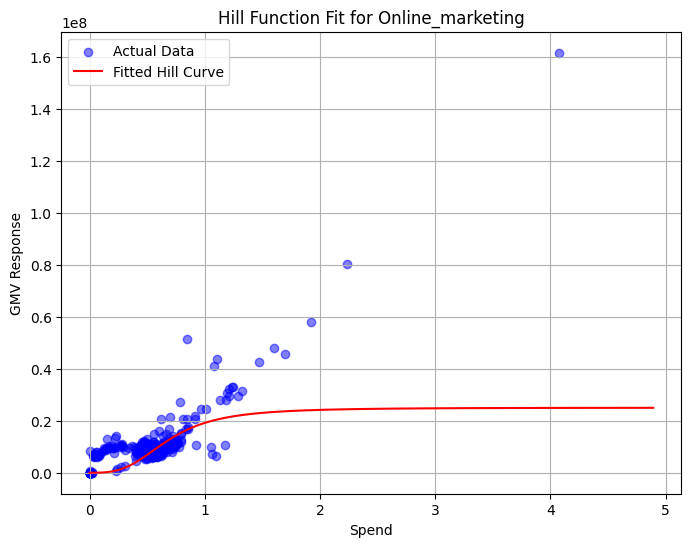

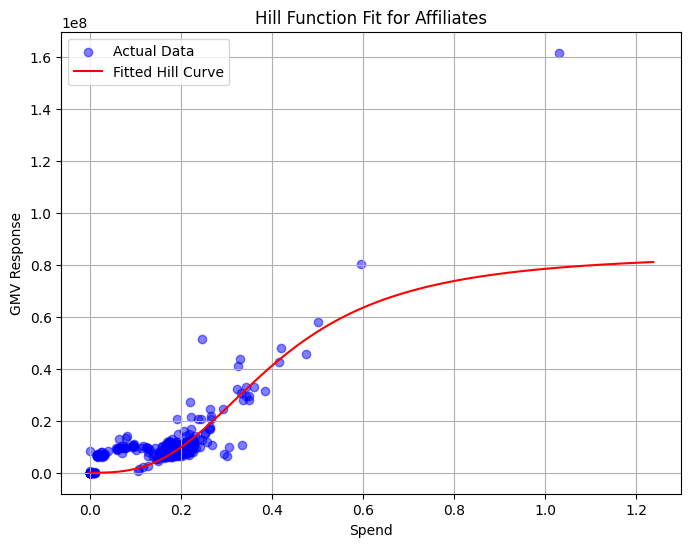

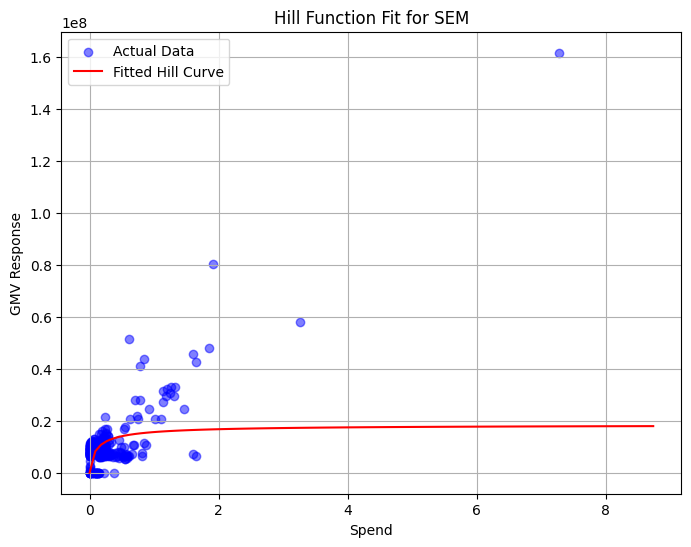

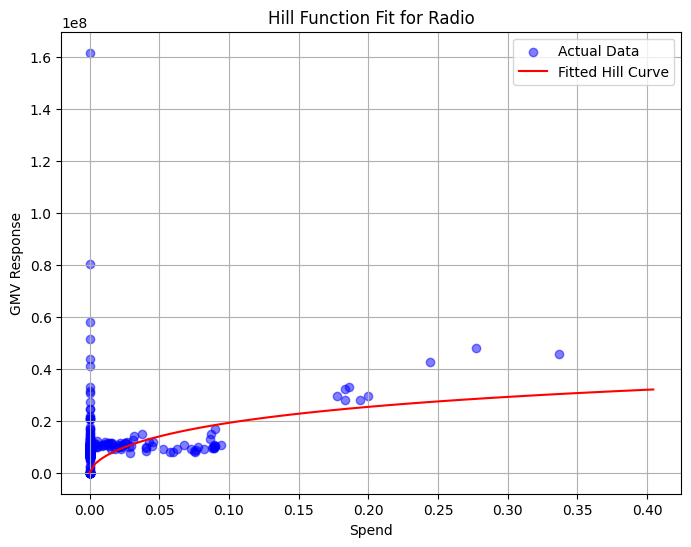

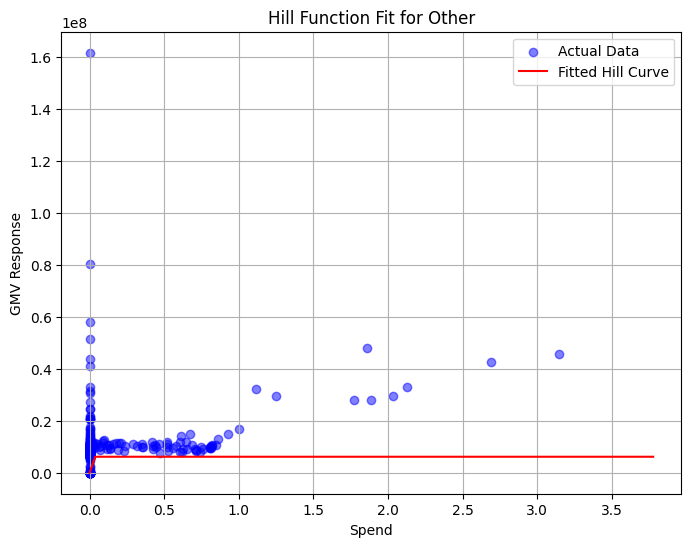

In [142]:
def plot_fitted_hill_curve(channel_spend, channel_gmv, beta, n, ec50, channel_name):
    """Plot the fitted Hill curve."""
    spend_range = np.linspace(0, max(channel_spend) * 1.2, 100)
    fitted_responses = hill_function(spend_range, beta, n, ec50)

    plt.figure(figsize=(8, 6))
    plt.scatter(channel_spend, channel_gmv, label="Actual Data", color='blue', alpha=0.5)
    plt.plot(spend_range, fitted_responses, label="Fitted Hill Curve", color='red')
    plt.title(f"Hill Function Fit for {channel_name}")
    plt.xlabel("Spend")
    plt.ylabel("GMV Response")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
for channel in MARKETING_CHANNELS:
    channel_spend = data[channel]
    channel_gmv = data['gmv']
    beta = channel_coefficients[channel]['coefficient']
    n, ec50 = hill_coefficients[channel], half_saturation_points[channel]
    plot_fitted_hill_curve(channel_spend, channel_gmv, beta, n, ec50, channel)

In [143]:
channel_coefficients = {channel: details['coefficient'] for channel, details in channel_coefficients.items()}
channel_coefficients

{'TV': np.float64(70682538.8475134),
 'Digital': np.float64(43401437.63299123),
 'Sponsorship': np.float64(5868510.33892793),
 'Content_Marketing': np.float64(164334689.51745135),
 'Online_marketing': np.float64(25021018.083708905),
 'Affiliates': np.float64(84394631.33820708),
 'SEM': np.float64(18516539.69985048),
 'Radio': np.float64(60542906.918498516),
 'Other': np.float64(6143668.905600394)}

In [144]:
def calculate_roi_based_bounds(total_spend_per_channel, channel_coefficients, min_percentage=0.3, max_multiple=1.2):
    min_allocation = {}
    max_allocation = {}

    for channel in total_spend_per_channel.keys():
        roi = abs(channel_coefficients[channel]) / (total_spend_per_channel[channel] or 1)
        roi_adjustment = min(max(roi / 10000, 1), 1.2)
        # Adjust max allocation based on ROI
        min_allocation[channel] = total_spend_per_channel[channel] * min_percentage
        max_allocation[channel] = total_spend_per_channel[channel] * max_multiple * roi_adjustment

    return min_allocation, max_allocation

def optimize_budget_allocation(total_marketing_budget, min_allocation, max_allocation,
                               saturation_levels, hill_coefficients, half_saturation_points,
                               channel_coefficients, total_days, baseline_gmv):
    print("Setting up Gurobi optimization...")

    # Create a new Gurobi model
    model = gp.Model("MarketingBudgetOptimization")

    # Decision variables: budget allocation per channel
    allocations = {}
    responses = {}
    for channel in MARKETING_CHANNELS:
        allocations[channel] = model.addVar(
            lb=min_allocation[channel],
            ub=max_allocation[channel],
            name=f"allocation_{channel}"
        )
        responses[channel] = model.addVar(lb=0, name=f"response_{channel}")

    # Budget constraint: Total allocation < total marketing budget (using epsilon)
    epsilon = 1e-6  # Small tolerance value to approximate strict inequality
    model.addConstr(
        gp.quicksum(allocations[channel] for channel in MARKETING_CHANNELS) <= total_marketing_budget - epsilon,
        "budget_constraint"
    )

    # Piecewise Linear (PWL) approximation for Hill function
    num_breakpoints = 100  # Number of breakpoints for PWL approximation
    for channel in MARKETING_CHANNELS:
        # Define breakpoints over the range from min to max allocation
        min_val = min_allocation[channel]
        max_val = max_allocation[channel]
        breakpoints = np.linspace(min_val, max_val, num_breakpoints)

        # Calculate response at each breakpoint using Hill function
        response_values = []
        for bp in breakpoints:
            normalized_spend = bp / saturation_levels[channel]
            response = channel_coefficients[channel] * (
                np.power(bp, hill_coefficients[channel]) /
                (np.power(half_saturation_points[channel], hill_coefficients[channel]) +
                np.power(bp, hill_coefficients[channel]))
            )

            response_values.append(response)

        # Add PWL constraint
        model.addGenConstrPWL(
            allocations[channel],
            responses[channel],
            breakpoints,
            response_values
        )

    # Objective: Maximize total GMV (baseline + sum of channel responses) with a penalty for excessive spending
    total_baseline_gmv = baseline_gmv * total_days
    penalty_factor = 0.01  # Small penalty factor to discourage unnecessary spending
    model.setObjective(
        total_baseline_gmv +
        gp.quicksum(responses[channel] for channel in MARKETING_CHANNELS) -
        penalty_factor * gp.quicksum(allocations[channel] for channel in MARKETING_CHANNELS),
        GRB.MAXIMIZE
    )

    # Set Gurobi parameters
    model.setParam('TimeLimit', 600)  # Time limit: 10 minutes
    model.setParam('MIPGap', 0.001)   # Optimality gap: 0.1%

    # Optimize the model
    print("Starting Gurobi optimization...")
    model.optimize()

    # Process results
    if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
        optimized_allocation = {channel: allocations[channel].X for channel in MARKETING_CHANNELS}
        expected_gmv = total_baseline_gmv + sum(responses[channel].X for channel in MARKETING_CHANNELS)
        print("\nGurobi optimization successful!")
        print(f"Expected GMV with optimized allocation: {expected_gmv:.2f}")
        print(f"Current GMV: {total_gmv:.2f}")
        print(f"Expected improvement: {((expected_gmv / total_gmv) - 1) * 100:.2f}%")
        return optimized_allocation, expected_gmv
    else:
        print(f"Optimization failed with status {model.status}")
        return None, None

optimized_allocation, expected_gmv = optimize_budget_allocation(
    total_marketing_budget,
    min_allocation,
    max_allocation,
    saturation_levels,
    hill_coefficients,
    half_saturation_points,
    channel_coefficients,
    total_days,
    train_baseline_gmv
)

def analyze_investment_and_revenue_changes(total_spend_per_channel, optimized_allocation, total_gmv, expected_gmv):
    print("\n" + "="*50)
    print("INVESTMENT AND REVENUE ANALYSIS")
    print("="*50)

    # 1. Calculate total investment changes
    print("\nChannel-wise Investment Changes:")
    print(f"{'Channel':<20} {'Original ($)':<15} {'Optimized ($)':<15} {'% Change':<10}")
    for channel in MARKETING_CHANNELS:
        original = total_spend_per_channel[channel]
        optimized = optimized_allocation[channel]
        percent_change = ((optimized / original) - 1) * 100 if original > 0 else 0
        print(f"{channel:<20} {original:<15.2f} {optimized:<15.2f} {percent_change:<10.2f}%")

    # 2. Calculate total revenue changes
    print("\nRevenue Changes:")
    print(f"Original Total Revenue: ${total_gmv:.2f}")
    print(f"Optimized Total Revenue: ${expected_gmv:.2f}")
    revenue_percent_change = ((expected_gmv / total_gmv) - 1) * 100
    print(f"Percentage Change in Revenue: {revenue_percent_change:.2f}%")

# Execute analysis
analyze_investment_and_revenue_changes(
    total_spend_per_channel,
    optimized_allocation,
    total_gmv,
    expected_gmv
)

def calculate_investment_changes(total_spend_per_channel, optimized_allocation):
    total_original = sum(total_spend_per_channel.values())
    total_optimized = sum(optimized_allocation.values())

    print("\nTotal Investment Changes:")
    print(f"Original Total Investment: ${total_original:.2f}")
    print(f"Optimized Total Investment: ${total_optimized:.2f}")
    total_percent_change = ((total_optimized / total_original) - 1) * 100 if total_original > 0 else 0
    print(f"Percentage Change in Total Investment: {total_percent_change:.2f}%")

calculate_investment_changes(total_spend_per_channel, optimized_allocation)

Setting up Gurobi optimization...
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.001
Starting Gurobi optimization...
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.001

Optimize a model with 1 rows, 18 columns and 9 nonzeros
Model fingerprint: 0x1922b21b
Model has 9 simple general constraints
  9 PWL
Variable types: 18 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 5e+02]
  RHS range        [8e+02, 8e+02]
  PWLCon x range   [1e+00, 5e+02]
  PWLCon y range   [6e+06, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve added 18 rows and 891 columns
Presolve tim